In [70]:
!pip install tensorflow_decision_forests
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.0 MB/s eta 0:00:00


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import keras_tuner as kt
from sklearn.datasets import load_iris

# Google Course Summary

*   A decision tree is a model composed of a collection of conditions organized hierarchically in the shape of a tree. Conditions fall into various categories:
> 1. An axis-aligned condition involves only a single feature. An oblique condition involves multiple features.
> 2. A binary condition has two possible outcomes. A non-binary condition has more than two possible outcomes.
* Training a decision tree involves searching for the best condition at each node. The splitter routine uses metrics such as information gain or Gini to determine the best condition.
* A decision forest is a mode made of multiple decision trees. The prediction of a decision forest is the aggregation of the predictions of its decision trees.
* A random forest is an ensemble of decision trees in which each decision tree is trained with a specific random noise.
* Bagging is a technique in which each decision tree in the random forest is trained on a different subset of examples.
* Random forests do not require a validation dataset. Instead, most random forests use a technique called out-of-bag-evaluation to evaluate the quality of the model.
* A gradient boosted (decision) tree is a type of decision forest trained through iterative adjustments from input decision trees. A value called shrinkage controls the rate at which a gradient boosted (decision) tree learns and the degree to which it could overfit.

# **Classification** - IRIS Flowers
---
150 examples from 3 balenced (50/50/50) classes

> Features (sepal length, sepal width, petal length, petal width)

> Target Class (Iris setosa, Iris versicolor, or Iris virginica)
---






In [72]:
X, Y = load_iris(return_X_y=True, as_frame=True)
print("Classes are balenced ",Y.value_counts(), sep="\n")

Classes are balenced 
0    50
1    50
2    50
Name: target, dtype: int64


In [73]:
print("Dataset is sorted, target is already categorical")
dataset = X.join(Y)
dataset.head(10)

Dataset is sorted, target is already categorical


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


# Data Split

training ~80%, test ~20%

Visually confirming label is distributed within ~0.1 for test and training split

In [74]:
np.random.seed(5)
# Use the ~25% of the examples as the testing set
# and the remaining ~75% of the examples as the training set.
test_indices = np.random.rand(len(dataset)) < 0.25
pd_train_dataset = dataset[~test_indices]
pd_test_dataset = dataset[test_indices]

label = "target"
print("Training examples: ", len(pd_train_dataset))
print(pd_train_dataset[label].describe())
# >> Training examples: 110

print("\nTesting examples: ", len(pd_test_dataset))
print(pd_test_dataset[label].describe())
# >> Testing examples: 40

Training examples:  111
count    111.0000
mean       1.0000
std        0.8202
min        0.0000
25%        0.0000
50%        1.0000
75%        2.0000
max        2.0000
Name: target, dtype: float64

Testing examples:  39
count    39.00000
mean      1.00000
std       0.82717
min       0.00000
25%       0.00000
50%       1.00000
75%       2.00000
max       2.00000
Name: target, dtype: float64


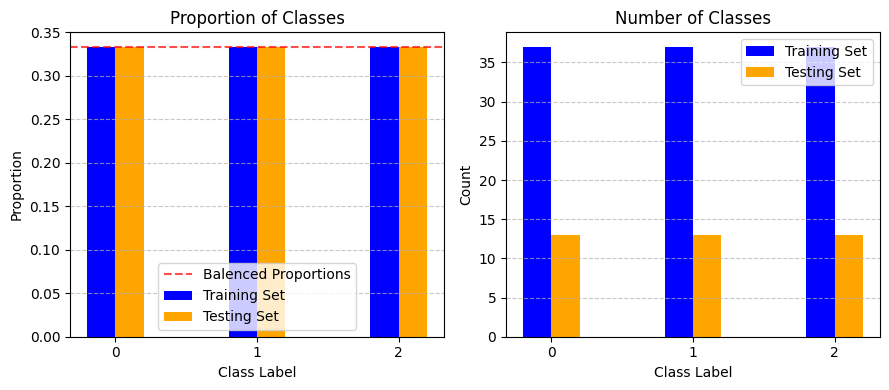

In [77]:
# Calculate class proportions and counts
class_proportions_train = pd_train_dataset["target"].value_counts(normalize=True, sort=False)
class_proportions_test = pd_test_dataset["target"].value_counts(normalize=True, sort=False)

class_counts_train = pd_train_dataset["target"].value_counts(normalize=False, sort=False)
class_counts_test = pd_test_dataset["target"].value_counts(normalize=False, sort=False)

# Create the plot with consistent bar width
plt.figure(figsize=(9, 4))

# Subplot 1: Proportions
plt.subplot(121)
plt.bar([0,1,2], class_proportions_train.values, width=0.2, label='Training Set', color='blue')  # Keep bar width at 0.2
plt.bar([0.2,1.2,2.2], class_proportions_test.values, width=0.2, label='Testing Set', color='orange')  # Keep bar width at 0.2
plt.axhline(y=0.333333,linestyle='--', alpha = 0.7, color = 'red', label = "Balenced Proportions")
plt.xticks([0.1,1.1,2.1], [0, 1, 2], rotation=0)  # Adjusted xticks
plt.title("Proportion of Classes")
plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Counts
plt.subplot(122)
plt.bar([0, 1, 2], class_counts_train.values, width=0.2, label='Training Set', color='blue')  # Keep bar width at 0.2
plt.bar([0.2, 1.2, 2.2], class_counts_test.values, width=0.2, label='Testing Set', color='orange')  # Keep bar width at 0.2
plt.xticks([0.1,1.1,2.1], [0, 1, 2], rotation=0)  # Adjusted xticks
plt.title("Number of Classes")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [78]:
tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pd_train_dataset, label=label)
tf_test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pd_test_dataset, label=label)

# Decision Tree

In [76]:
def build_model(hp):
  model = tfdf.keras.CartModel(
      min_examples=hp.Choice("min_examples",
          # Try four possible values for "min_examples" hyperparameter.
          # min_examples=10 would limit the growth of the decision tree,
          # while min_examples=1 would lead to deeper decision trees.
         [1, 2, 5, 10]),
      validation_ratio=hp.Choice("validation_ratio",
         # Three possible values for the "validation_ratio" hyperparameter.
         [0.0, 0.05, 0.10]),
      )
  model.compile("accuracy")
  return model

tuner = kt.GridSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory="/tmp/tuner",
    project_name="tune_cart")

tuner.search(x=tf_train_dataset, validation_data=tf_test_dataset)
best_model = tuner.get_best_models()[0]

print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)
# >> Best hyperparameters:  {'min_examples': 2, 'validation_ratio': 0.0}

Use /tmp/tmpfncl7hzb as temporary training directory


NameError: name 'tf_train_dataset' is not defined

# Random Forest


# Gradient Boosted Tree